In [1]:
import numpy as np
import os
import matplotlib
from unityagents import *
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [14]:
### General parameters
max_steps = 1e4 # Set maximum number of steps to run environment.
run_path = "dqn" # The sub-directory name for model and summary statistics
load_model = False # Whether to load a saved model.
train_model = True # Whether to train the model.
summary_freq = 10000 # Frequency at which to save training statistics.
save_freq = 50000 # Frequency at which to save model.
env_name = "UFOGridWorld_table" # Name of the training environment file.
curriculum_file = None

### Algorithm-specific parameters for tuning
gamma = 0.99 # Reward discount rate.
epsilon_start = 1.0 # Initial probablity of random acction
epsilon_end = 0.001 # Final probability of random action
epsilon_decay_steps = 8e3 # Number of steps between epsilon_start and epsilon_end
alpha = 0.8 # Learning rate
normalize = False

### Logging dictionary for hyperparameters

hyperparameter_dict = {'max_steps':max_steps, 'run_path':run_path, 'env_name':env_name,
    'curriculum_file':curriculum_file, 'gamma':gamma}

In [15]:
def create_policy(a_size):
    """
    Creates epsilon-greedy policy
    :param a_size: Action space size
    :return prob: Policy function 
    """
    def policy(best_action, epsilon):
        """
        Applies epsilon-greedy policy
        :param best_action: Action yielding the maximum Q-value according to our table
        :param epsilon: Probability of selecting a random action
        :return action: Chosen action
        """
        prob = np.ones(a_size)*epsilon/a_size
        prob[best_action] += 1 - epsilon
        action = np.random.choice(a_size, 1, p = prob)
        return action
    return policy

In [16]:
env = UnityEnvironment(file_name=env_name, curriculum=curriculum_file)
print(str(env))
brain_name = env.external_brain_names[0]

INFO:unityagents:
'UFOAcademy' started successfully!


Unity Academy name: UFOAcademy
        Number of brains: 1
        Reset Parameters :
		
Unity brain name: UFOBrain
        Number of observations (per agent): 0
        State space type: discrete
        State space size (per agent): 1
        Action space type: discrete
        Action space size (per agent): 4
        Memory space size (per agent): 0
        Action descriptions: , , , 


In [17]:
# Define epsilon decay schedule
epsilon = epsilon_start
epsilon_decay = (epsilon_start - epsilon_end)/epsilon_decay_steps
a_size = env.brains[brain_name].action_space_size
s_size = env.brains[brain_name].state_space_size

# Initialize lookup table
Q = np.zeros((16, a_size))
policy = create_policy(a_size)

info = env.reset()[brain_name]
reward = 0
steps = 0
episodes = 0
reward_list = []
epsilon_list = []
steps_list = []
while steps <= max_steps:
    # Decide and take an action
    best_action = np.argmax(Q[info.states.astype(int), :])
    action = policy(best_action, epsilon)
    new_info = env.step(action)[brain_name]
    # Calculate target
    target = new_info.rewards[0] + gamma*np.invert(new_info.local_done[0])*np.max(Q[new_info.states.astype(int),:])
    # Update table toward target
    Q[info.states.astype(int), action] += alpha*(target - Q[info.states.astype(int), action])
    # Increase number of total steps and reduce epsilon
    steps += 1
    if epsilon > epsilon_end:
        epsilon += -epsilon_decay
    epsilon_list.append(epsilon)
    # Calculate total episode reward
    reward += new_info.rewards[0]
    info = new_info
    
    # If episode is over start new episode
    if info.local_done[0]:
        info = env.reset()[brain_name]
        episodes += 1
        if episodes % 1e3 == 0:
            print('steps: ' + str(steps) + ' reward: ' + str(reward))
        # Store total reward
        reward_list.append(reward)
        steps_list.append(steps)
        reward = 0
    
        
env.close()


steps: 6646 reward: 0.98
steps: 9767 reward: 0.98


Text(0,0.5,'Epsilon %')

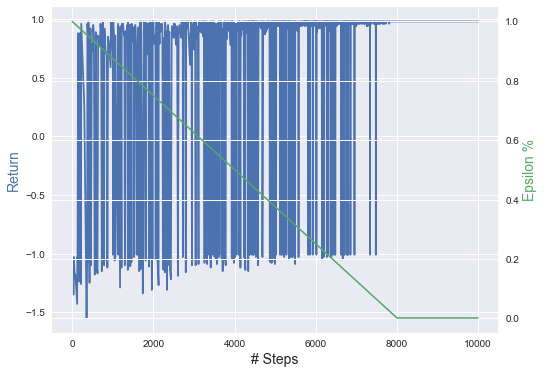

In [18]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(8,6))
ax1.grid(False)
last = 0
weight = 0
smoothed_reward = np.zeros(len(reward_list))
for i in range(len(reward_list)):
    smoothed_reward[i] = last*weight + (1-weight)*(reward_list[i])
    last = smoothed_reward[i]
ax1.plot(steps_list,smoothed_reward, color="C0")
ax1.set_ylabel("Return", fontsize=14, color="C0")
ax1.set_xlabel("# Steps", fontsize=14)
ax2 = ax1.twinx()
ax2.grid(False)
ax2.plot(epsilon_list, lw=1.5, color="C1")
ax2.set_ylabel("Epsilon %", fontsize=14, color="C1")


In [1]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
maxQ = np.amax(Q, axis = 1)
maxQ = maxQ.reshape(4,4)
maxQ[3,2] = np.nan
maxQ[1,3] = np.nan
colormap = plt.cm.cubehelix_r
fig, ax = plt.subplots(figsize=(8,6)) 
ax = sns.heatmap(maxQ, annot=True, cmap="RdYlGn")
ax.invert_yaxis()

NameError: name 'np' is not defined